# BaseLine Code

- 약 106개의 이미지만을 사용하여 만든 baseline code

## Step 1. 실험환경 set-up

#### 라이브러리 실행

In [1]:
from tensorflow.keras.models import Sequential, load_model

import os           
import numpy             as np  
import tensorflow        as tf
import matplotlib.pyplot as plt

#### 필요한 변수들 생성

In [2]:
IMAGE_SIZE = [1024, 1360]                  # 이미지 사이즈 변수
BATCH_SIZE = 32                            # BATCH_SIZE 변수
EPOCHS     = 150                           # EPOCH 크기 변수
AUTOTUNE   = tf.data.experimental.AUTOTUNE # 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수

#### GPU 사용 여부보기

In [2]:
gpus = tf.config.experimental.list_logical_devices("GPU")

if len(gpus) > 1:
    strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
    print(f"Running on multiple GPUs {[gpu.name for gpu in gpus]}")

elif len(gpus) == 1:
    strategy = tf.distribute.get_strategy()
    print(f"Running on single GPU {gpus[0].name}")

else:
    strategy = tf.distribute.get_strategy()
    print("Running on CPU")

print(f"Number of accelerators: {strategy.num_replicas_in_sync}")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Step 2. 데이터 준비하기

먼저 아래의 링크에서 데이터를 다운 받을 것

https://drive.google.com/drive/folders/1Pi5qyX080zY2IdGT1TvvLraBO9DHBxJl?usp=sharing

받은 후 터미널 창에 아래의 명령어들을 차례로 입력

```
$ cd ~/Downloads && cp CellPin ~/aiffel
```

#### 데이터의 개수 확인

In [3]:
# 데이터 ROOT 경로 변수
ROOT_PATH = os.path.join(os.getenv("HOME"), "aiffel/CellPin")
print(ROOT_PATH)

# 각 데이터 불러오기
train_filenames = tf.io.gfile.glob(str(ROOT_PATH + "/train/*/*"))
test_filenames  = tf.io.gfile.glob(str(ROOT_PATH + "/test/*/*"))
val_filenames   = tf.io.gfile.glob(str(ROOT_PATH + "/val/*/*"))

# 데이터 갯수 확인하기
print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

/home/aiffel-dj52/aiffel/CellPin
188


#### train 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [6]:
COUNT_NORMAL = len([filename for filename in train_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in train_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 28
CPE images count in training set: 92


#### val 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [7]:
COUNT_NORMAL = len([filename for filename in val_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in val_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 6
CPE images count in training set: 24


#### test 데이터 안에 정상 이미지 수와 CPE 이미지 수

In [8]:
COUNT_NORMAL = len([filename for filename in test_filenames if "normal" in filename])
print("NORMAL images count in training set: " + str(COUNT_NORMAL))

COUNT_CPE = len([filename for filename in test_filenames if "cpe" in filename])
print("CPE images count in training set: " + str(COUNT_CPE))

NORMAL images count in training set: 5
CPE images count in training set: 33


#### tf.data 인스턴스를 만들기

In [9]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds   = tf.data.Dataset.from_tensor_slices(val_filenames)

#### train data와 val data의 개수 확인

In [10]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print("Training images count: " + str(TRAIN_IMG_COUNT))

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print("Validating images count: " + str(VAL_IMG_COUNT))

Training images count: 120
Validating images count: 30


#### 라벨 이름들 확인

In [11]:
CLASS_NAMES = np.array([str(tf.strings.split(item, os.path.sep)[-1].numpy())[2:-1]
                        for item in tf.io.gfile.glob(str(ROOT_PATH + "/train/*"))])
print(CLASS_NAMES)

['cpe' 'normal']


#### 라벨링 함수를 만들어 보기

In [12]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "cpe"

#### decode_img 함수와 process_path 함수를 만들기

In [13]:
def decode_img(img):
  # 이미지를 uint8 tensor로 바꾼다.
  img = tf.image.decode_jpeg(img, channels = 1)
    
  # img를 범위 [0,1]의 float32 데이터 타입으로 바꾼다.
  img = tf.image.convert_image_dtype(img, tf.float32)
    
  # img의 이미지 사이즈를 IMAGE_SIZE에서 지정한 사이즈로 수정한다.
  return tf.image.resize(img, IMAGE_SIZE)

def process_path(file_path):
    label = get_label(file_path)
    
    if label == True:
        label = ([0, 1])
    else:
        label = ([1, 0])
        
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    
    return img, label

#### train과 val에 함수들 적용해주기

In [14]:
train_ds = train_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
val_ds   = val_list_ds.map(process_path,   num_parallel_calls = AUTOTUNE)

#### 전처리 함수 만들기 및 적용

In [15]:
def prepare_for_training(ds, shuffle_buffer_size = 1000):
    ds = ds.shuffle(buffer_size = shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size = AUTOTUNE)

    return ds


train_ds = prepare_for_training(train_ds)
val_ds   = prepare_for_training(val_ds)

#### Image shape를 변경 체크하기

In [16]:
for image, label in train_ds.take(1):
    print("Image shape :", image.numpy().shape)
    print("Label :",       label.numpy().shape)

Image shape:  (32, 256, 256, 3)
Label:  [False False  True  True False  True False  True False  True  True  True
 False False  True  True False  True False  True  True  True  True  True
  True  True False  True  True False  True  True]


#### test 데이터 셋도 만들어 보기 & 데이터의 갯수 확인

In [17]:
test_list_ds     = tf.data.Dataset.list_files(str(ROOT_PATH + "/test/*/*"))
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds          = test_list_ds.map(process_path, num_parallel_calls = AUTOTUNE)
test_ds          = test_ds.batch(BATCH_SIZE)
print(TEST_IMAGE_COUNT)

## Step 3. 데이터 시각화

#### 16개의 샘플 꺼내서 확인

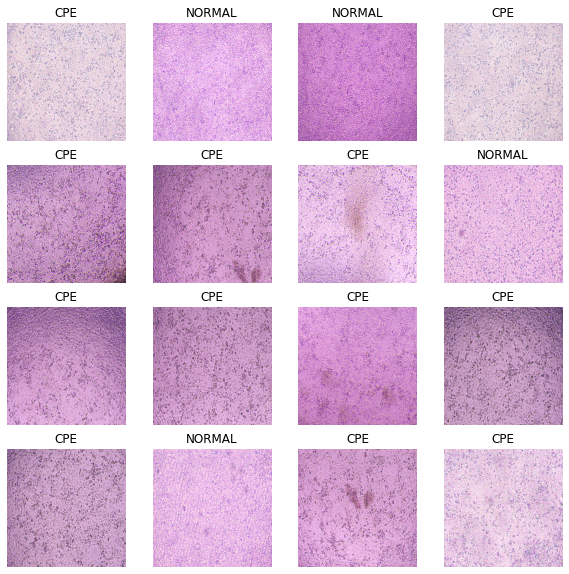

In [18]:
image_batch, label_batch = next(iter(train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize = (10,10))
    
    for n in range(16):
        ax = plt.subplot(4, 4, n + 1)
        plt.imshow(image_batch[n])
        
        if list(label_batch[n])[0].numpy() == 0:
            plt.title("CPE")
        else:
            plt.title("NORMAL")
        
        plt.axis("off")

        
show_batch(image_batch.numpy(), label_batch)

#### model building(ResNet)

In [19]:
resnet152 = tf.keras.applications.ResNet152V2(include_top           = True,
                                              weights               = None,
                                              input_shape           = (256, 256, 3),
                                              classes               = 2,
                                              classifier_activation = "softmax")

In [20]:
resnet152.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 130, 130, 64) 0           conv1_conv[0][0]                 
________________________________________________________________________________________

## Step 4. 모델 훈련

#### GPU사용하여 model complie

In [22]:
with strategy.scope():
    METRICS = [
        "accuracy",
        tf.keras.metrics.Precision(name = "precision"),
        tf.keras.metrics.Recall(name    = "recall")
    ]
    
    resnet152.compile(
        optimizer = "adam",
        loss      = "binary_crossentropy",
        metrics   = METRICS
    )
    
    check_point = tf.keras.callbacks.ModelCheckpoint(ROOT_PATH + "/pre_training_model/best_model_test.h5")

#### 모델 fitting

In [24]:
with strategy.scope():
    history = resnet152.fit(
        train_ds,
        steps_per_epoch  = TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs           = EPOCHS,
        validation_data  = val_ds,
        validation_steps = VAL_IMG_COUNT // BATCH_SIZE, # 2,
        callbacks        = [check_point]
    )

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/30
3/3 [==============================] - 85s 21s/step - loss: 6.8858 - accuracy: 0.7708 - precision: 0.7708 - recall: 1.0000 - val_loss: 0.6189 - val_accuracy: 0.7969 - val_precision: 0.7969 - val_recall: 1.0000


/home/aiffel-dj52/anaconda3/envs/aiffel/lib/python3.7/site-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/30
3/3 [==============================] - 54s 20s/step - loss: 4.0251 - accuracy: 0.7812 - precision: 0.7812 - recall: 1.0000 - val_loss: 0.7584 - val_accuracy: 0.8125 - val_precision: 0.8125 - val_recall: 1.0000
Epoch 3/30
3/3 [==============================] - 54s 20s/step - loss: 2.3311 - accuracy: 0.7812 - precision: 0.7812 - recall: 1.0000 - val_loss: 0.7387 - val_accuracy: 0.7812 - val_precision: 0.7812 - val_recall: 1.0000
Epoch 4/30
3/3 [==============================] - 54s 20s/step - loss: 0.4733 - accuracy: 0.7188 - precision: 0.7188 - recall: 1.0000 - val_loss: 0.9743 - val_accuracy: 0.7812 - val_precision: 0.7812 - val_recall: 1.0000
Epoch 5/30
3/3 [==============================] - 54s 20s/step - loss: 1.8822 - accuracy: 0.7812 - precision: 0.7812 - recall: 1.0000 - val_loss: 6.3661 - val_accuracy: 0.7969 - val_precision: 0.7969 - val_recall: 1.0000
Epoch 6/30
3/3 [==============================] - 54s 20s/step - loss: 2.6877 - accuracy: 0.7708 - precision: 0.7708

## Step 5. 결과 확인 및 시각화

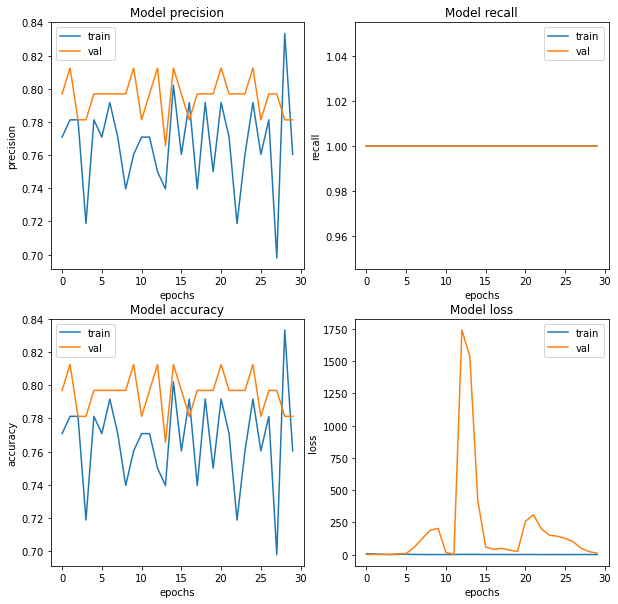

In [25]:
fig, ax = plt.subplots(2, 2, figsize = (10, 10))
ax      = ax.ravel()

for i, met in enumerate(["precision", "recall", "accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title(f"Model {met}")
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

## Step 6. 최종 Test dataset 검정하기

In [26]:
with strategy.scope():
    model = tf.keras.models.load_model(ROOT_PATH + "/pre_training_model/best_model_test.h5")
    
    loss, acc, prec, rec = model.evaluate(test_ds)

2/2 [==============================] - 7s 560ms/step - loss: 7.1038 - accuracy: 0.8684 - precision: 0.8684 - recall: 1.0000
